# MAE 298 Mini-Project 1: Report
William Hsieh 205579184

## Introduction

This project goes over a mini-grid approximation in two dimensions: slope and intercept. This model uses Bayesian learning in order to create "updates" for the weights $w_0$ and $w_1$. As new data points are added, weights change (visualized by heatmaps), which demonstrates how Bayesian learning takes the prior (current step) to update the weights for the posterior (next step). 

This report will provide an outline of how this project was finished, along with code examples and analysis interleaved.

## Packages and Seed

Necessary packages are imported below, and a random seed is set. I chose to use my UID as the seed.

In [16]:
# https://juliastats.org/Distributions.jl/stable/starting/
using Random, Distributions
using StatsPlots, Turing, Plots, JSON, StatsBase, StatsFuns, CSV, 
      DataFrames, LinearAlgebra, DifferentialEquations, Optim
using LaTeXStrings

Random.seed!(205579184) # Setting the seed

TaskLocalRNG()

## Initializing Our Variables

A unform distribution and Gaussian noise distribution are defined below, and these are used to generate synthetic data.

In [17]:
uniform_dist = Uniform(-1, 1)
gauss_noise = Normal(0, 0.2)

Normal{Float64}(μ=0.0, σ=0.2)

The "granularity" of our weights/values is defined below. While working on the code, I kept it at 50 to speed up calculations. The final verison of this report has plots generated with `N_g = 1000`.

In [18]:
N_g = 1000

1000

Synthetic data is now generated for $x$: data is sampled from the uniform distribution defined above. The target values $y$ are generated by taking those values and plugging it into this function:

$$f(x) = a_0 + a_1 x_n$$

Gaussian noise with a STD of $0.2$ is finally added.

In [19]:
x = rand(uniform_dist, N_g)
y = rand(uniform_dist, N_g)

a0 = -0.3
a1 = 0.5

for i in 1:N_g
    y[i] = a0 + a1 * x[i] + rand(gauss_noise)
end

# print("x: $x\ny: $y")
print("\n")

## Arrays

Next, necessary arrays are created (weights, prior, likelihood, posterior, and standardized posterior). $w_0$ and $w_1$ take the same shape as our input and target variables. The prior, likelihood, posterior, and standardized posterior are two-dimensional grids to be able to represent every value of $(w_0, w_1)$.

In [20]:
w0 = zeros(N_g)
w1 = zeros(N_g)
weight_noise = Normal(0, 0.25)
# print("w0: $w0\nw1: $w1\n")

prior = zeros(N_g, N_g)
likelihood = zeros(N_g, N_g)
posterior = zeros(N_g, N_g)
posterior_normed = zeros(N_g, N_g)

# print("prior: $prior")
print("\n")

Now, $w_0$ and $w_1$ are populated, each containing values from $-1$ and $1$ that are equally spaced. Using math, we can fill in those values.

In [21]:
for i in 1:N_g
    w0[i] = -1 + 2 * (i - 1) / (N_g - 1)
    w1[i] = -1 + 2 * (i - 1) / (N_g - 1)
end
# print("w0: $w0\nw1: $w1\n")
print("\n")

## Initial Prior

To calculate the initial prior, we can use the following:

$$\text{prior[i, j]} = \frac{1}{\sigma_{w_0} \sqrt{2\pi}} \exp \left( -\frac{w_0^2}{2\sigma_{w_0}^2} \right)
\cdot \frac{1}{\sigma_{w_1} \sqrt{2\pi}} \exp \left( -\frac{w_1^2}{2\sigma_{w_1}^2} \right)$$

This is simplified using the built-in `pdf()` function. Note that the code has `[j, i]` instead of `[i, j]`. This only changes the visual representation of the plots and is done to conform with standard method of drawing x-y coordinates.

In [22]:
for i in 1:N_g
    for j in 1:N_g
        prior[j, i] = pdf(weight_noise, w0[i]) * 
                      pdf(weight_noise, w1[j])
    end
end

Plotting this gives the following prior:

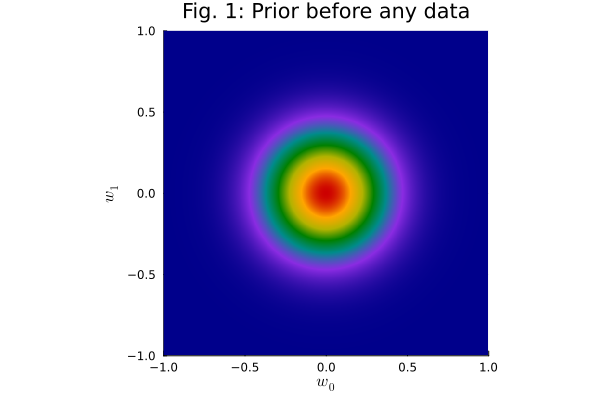

In [23]:
prior_posterior_1 = heatmap(w0, w1, prior, xlabel=L"w_0", 
    ylabel=L"w_1", xlim=extrema(w0), ylim=extrema(w1), 
    fill = (true,cgrad(:darktest)), aspect_ratio=:equal, 
    title="Fig. 1: Prior before any data", legend=:none)

Since we didn't create any updates yet, it makes sense that the most likely values of $w_0$ and $w_1$ would be $0$ and $0$, as seen in Fig. 1. Now, we want to take a random data point and update via Bayes' theorem.

## Updating Via Bayes' Theorem

First, to take a random data point (recall $f(x) = a_0 + a_1 x_n$):

In [24]:
x_likelihoods = rand(Uniform(-1, 1)) + rand(Normal(0, 0.2))
y_likelihoods = a0 + a1 * x_likelihoods

0.21451501568199233

Next, we want to perform the update for a single step. Using our random point, we can calculate the likelihood via:

$$\text{likelihood[i, j]} = \frac{1}{\sigma \sqrt{2\pi}} \exp \left( -\frac{y_k - (w_0 + w_1 x_k)}{2\sigma^2} \right)$$

Using this likelihood and the prior from before, we can calculate the posterier by simply multiplying.

Finally, the `evidence` is used to normalize the posterior. All together, the code looks like this:

In [25]:
evidence = 0

for i in 1:N_g
    for j in 1:N_g
        likelihood[j, i] = pdf(
            Normal(w0[i] + w1[j] * x_likelihoods, 0.2), 
            y_likelihoods)
            
        posterior[j, i] = likelihood[j, i] * prior[j, i]
        evidence += posterior[j, i]
    end
end

posterior_normed = posterior / evidence
print("\n")

Plotting the likelihood and the posterior after this step gives:

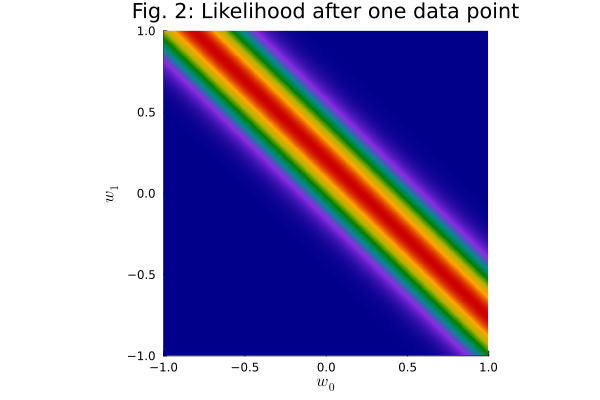

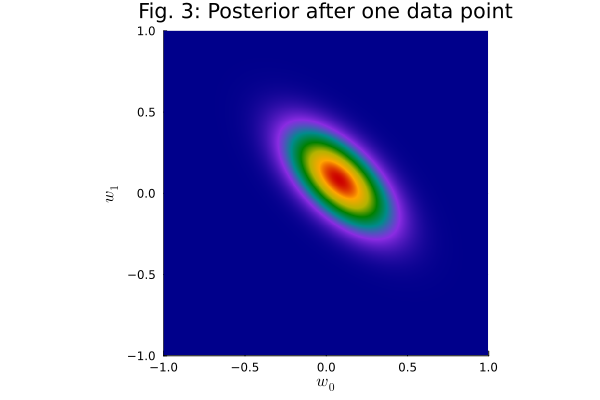

In [26]:
likelihood_2 = heatmap(w0, w1, likelihood, xlabel=L"w_0", 
    ylabel=L"w_1", xlim=extrema(w0), ylim=extrema(w1), 
    fill = (true,cgrad(:darktest)), aspect_ratio=:equal, 
    title="Fig. 2: Likelihood after one data point", legend=:none)
display(likelihood_2)

prior_posterior_2 = heatmap(w0, w1, posterior_normed, xlabel=L"w_0", 
    ylabel=L"w_1", xlim=extrema(w0), ylim=extrema(w1), 
    fill = (true,cgrad(:darktest)), aspect_ratio=:equal, 
    title="Fig. 3: Posterior after one data point", legend=:none)

Fig. 2 shows the likelihood which was multiplied by the prior to get the posterior. The trend in this heatmap will become more apparent after more data points are used to update. Fig. 3 shows the posterior start to "stretch" in the same direction as the likelihood, but the center did not move much compared to the prior. Let's repeat this step with nother data point and see the corresponding update.

## Second Update

Note that the prior is now the posterior from before. Intuitively, we are using the results of the first data point to evaluate the result of our second data point.

In [27]:
evidence = 0

x_likelihoods = rand(Uniform(-1, 1)) + rand(Normal(0, 0.2))
y_likelihoods = a0 + a1 * x_likelihoods

for i in 1:N_g
    for j in 1:N_g
        likelihood[j, i] = pdf(
            Normal(w0[i] + w1[j] * x_likelihoods, 0.2), 
            y_likelihoods)

         # Use posterior from previous iteration
        posterior[j, i] = likelihood[j, i] * posterior_normed[j, i]
        evidence += posterior[j, i]
    end
end

posterior_normed = posterior / evidence
print("\n")

Plotting these now gives us more apparent differences:

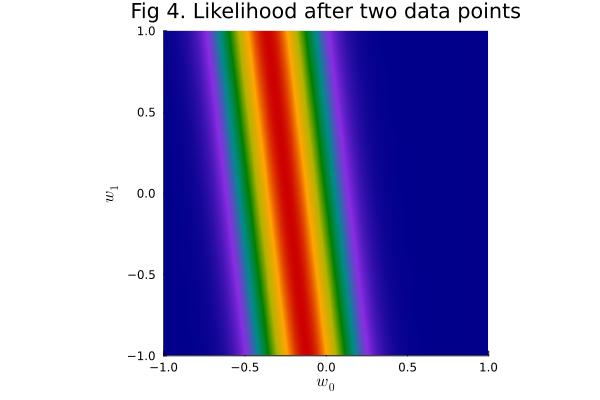

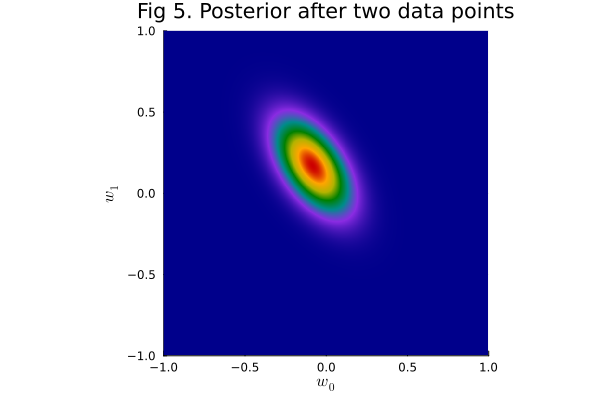

In [28]:
likelihood_3 = heatmap(w0, w1, likelihood, xlabel=L"w_0", 
    ylabel=L"w_1", xlim=extrema(w0), ylim=extrema(w1), 
    fill = (true,cgrad(:darktest)), aspect_ratio=:equal, 
    title="Fig 4. Likelihood after two data points", legend=:none)
display(likelihood_3)

prior_posterior_3 = heatmap(w0, w1, posterior_normed, xlabel=L"w_0", 
    ylabel=L"w_1", xlim=extrema(w0), ylim=extrema(w1), 
    fill = (true,cgrad(:darktest)), aspect_ratio=:equal, 
    title="Fig 5. Posterior after two data points", legend=:none)

Fig. 4 shows how the likelihood changed due to that second (randomly chosen) data point. The drastic change in the likelihood compared to the previous step also affects the posterior a lot. We can see that our posterior has now shifted over and is closer to those initial values. To interpret it, Fig. 5 shows how the new predictions for $w_0$ and $w_1$ are now moving closer to our actual values of $a_0 = -0.3$ and $a_1 = 0.5$.

## More Updates

Repeating the last step 18 more times gives us a total of 20 data points that are used to create the likelihood/posteriors.

In [29]:
for iter in 1:18
    evidence = 0

    x_likelihoods = rand(Uniform(-1, 1)) + rand(Normal(0, 0.2))
    y_likelihoods = a0 + a1 * x_likelihoods

    for i in 1:N_g
        for j in 1:N_g
            likelihood[j, i] = pdf(
                Normal(w0[i] + w1[j] * x_likelihoods, 0.2), 
                y_likelihoods)
             # Use posterior from previous iteration
            posterior[j, i] = likelihood[j, i] * posterior_normed[j, i]
            evidence += posterior[j, i]
        end
    end

    posterior_normed = posterior / evidence
end

Plotting the results:

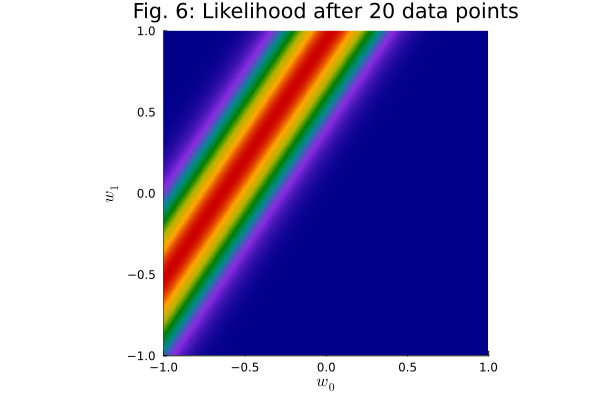

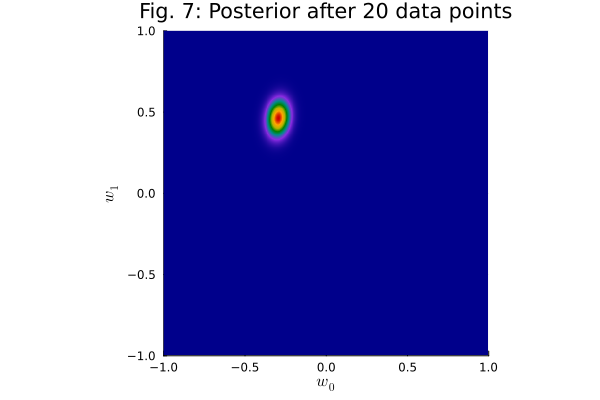

In [30]:
likelihood_4 = heatmap(w0, w1, likelihood, xlabel=L"w_0", 
    ylabel=L"w_1", xlim=extrema(w0), ylim=extrema(w1), 
    fill = (true,cgrad(:darktest)), aspect_ratio=:equal, 
    title="Fig. 6: Likelihood after 20 data points", legend=:none)
display(likelihood_4)

prior_posterior_4 = heatmap(w0, w1, posterior_normed, xlabel=L"w_0", 
    ylabel=L"w_1", xlim=extrema(w0), ylim=extrema(w1), 
    fill = (true,cgrad(:darktest)), aspect_ratio=:equal, 
    title="Fig. 7: Posterior after 20 data points", legend=:none)

Fig. 6 shows the likelihood from the last step, which has not changed much from the second step. At this point, it is quite likely that the "predicted" weights are close to their actual values. This can be confirmed by looking at the posterior in Fig. 7, where $w_0$ is very close to $-0.3$ and $w_1$ is very close to $0.5$. 

Compared to the posterior after one or two data points, it is much more "confident" about the predicted values of the weights. As the number of data points increases, the red areas of the heatmap decreases.